## Time to get your hands dirty! Supernova distances and redshifts (part 1)
###  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

In [66]:
from astroML.datasets import generate_mu_z
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import NadarayaWatson
from astroML.linear_model import BasisFunctionRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova (produced by the merger of two white dwarfs ) which are standard candles, i.e. astrophysical objects with a known brightness. 

Let's recall the definition of the distance modulus:
$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5;
$$

where the apparent magnitude $m$ is a measure of the brightness of a celestial object as seen from Earth. It is a logarithmic scale where lower (or more negative) values indicate brighter objects, and higher values indicate dimmer ones.

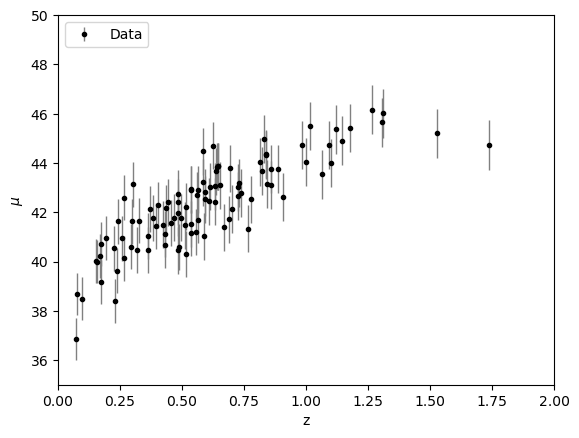

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)  #Generating the data with their errors

#Scatter plot of the data
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

In [3]:
z_grid = np.linspace(0.05, 2., 1000)

## Linear Regression

In [4]:
lin_reg = LinearRegression()  #Defining the Linear Regression estimator object
lin_reg.fit(z_sample[:, np.newaxis], mu_sample, sample_weight=1.0/dmu**2)  #Fitting the data

#Computing and printing the parameters
theta0 = lin_reg.intercept_  
theta1 = lin_reg.coef_
print(theta0, theta1[0])

39.483846022957295 4.7643886477497945


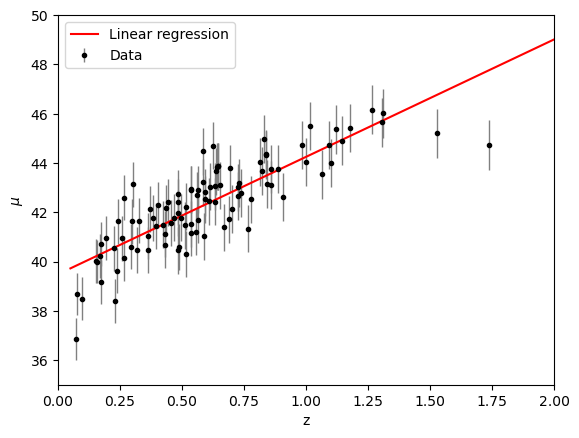

In [5]:
#Plotting the result
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.plot(z_grid, lin_reg.predict(z_grid[:, np.newaxis]), color = 'red', label='Linear regression')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

Here we are underfitting the data.

## Polynomial Regression

In [6]:
#Defining the function to perform polynomial regression
def poly(degree):
    model = PolynomialRegression(degree)  #Defining the Polynomial Regression estimator object
    model.fit(z_sample[:,np.newaxis], mu_sample, dmu)  #Fitting the data
    return model.predict(z_grid[:,np.newaxis])  #Computing the predictions

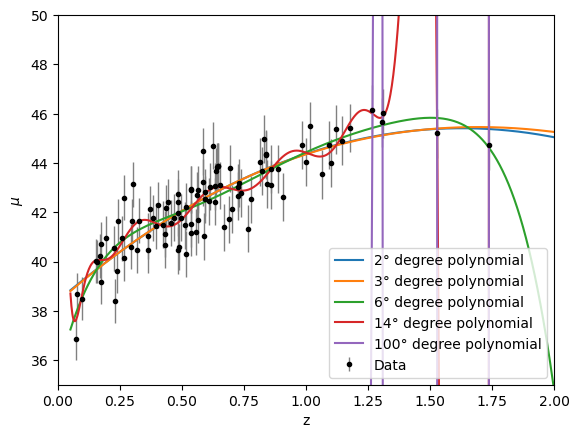

In [7]:
#Plotting the results of the polynomial regression for different degrees
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.plot(z_grid, poly(2), label='2° degree polynomial')
plt.plot(z_grid, poly(3), label='3° degree polynomial')
plt.plot(z_grid, poly(6), label='6° degree polynomial')
plt.plot(z_grid, poly(14), label='14° degree polynomial')
plt.plot(z_grid, poly(100), label='100° degree polynomial')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

We can see that the polynomials with 14 and 100 degrees overfit the data, instead the polynomials with 2, 3 and 6 degrees adapt pretty well to the data. We have to use cross validation to determine which one is better.

## Basis function regression

In [49]:
#Defining the function to perform basis function regression. In this case we use a gaussian function.
def basis(sigma):
    basis = BasisFunctionRegression('gaussian', mu=np.linspace(min(z_sample), max(z_sample), 10)[:, np.newaxis], 
                                    sigma=sigma)  #Defining the basis function regression estimator object
    basis.fit(z_sample[:,np.newaxis], mu_sample, dmu)  #Fitting the data
    return basis.predict(z_grid[:, np.newaxis])  #Computing the predictions

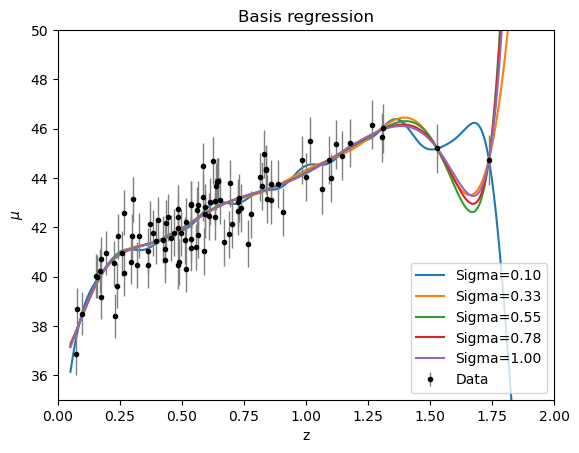

In [50]:
#Plotting the results of the basis function regression for different sigmas
sigma = np.linspace(0.1, 1, 5)
for s in sigma:
    plt.plot(z_grid, basis(s), label='Sigma=%0.2f' %s)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.title('Basis regression')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

Here we are overfitting for all the values of sigma. In fact, we should also have to tune the number of gaussians. To obtain a better result we have to cross validate both of these hyperparameters.

## Kernel regression

In [51]:
#Defining the function to perform kernel regression. In this case we use a gaussian kernel.
def kernel(bw):
    kernel = NadarayaWatson(kernel='gaussian', h=bw)  #Defining the basis function regression estimator object
    kernel.fit(z_sample[:,np.newaxis], mu_sample, dmu)  #Fitting the data
    return kernel.predict(z_grid[:, np.newaxis])  #Computing the predictions

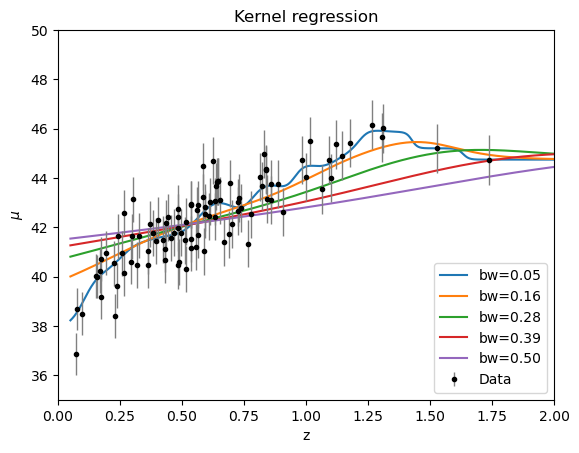

In [52]:
#Plotting the results of the kernel regression for different bandwidths
bws = np.linspace(0.05, 0.5, 5)
for h in bws:
    plt.plot(z_grid, kernel(h), label='bw=%0.2f' %h)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.title('Kernel regression')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Cross Validation

#### Polynomial regression

In [64]:
degreerange = np.arange(1, 11)
k = 10  #Number of k-fold
grid_deg = GridSearchCV(PolynomialRegression(), {'degree': degreerange}, cv= k,               #Defining the CV estimator object
                         scoring = 'neg_root_mean_squared_error', return_train_score = True)  #In this case we are using the RMS as loss function
grid_deg.fit(z_sample[:,np.newaxis], mu_sample, y_error = dmu)  #Fiitng our data
best_degree = grid_deg.best_params_['degree']  #Finding the best parameter
print('The best degree for the polynomial regression is', best_degree)

The best degree for the polynomial regression is 2


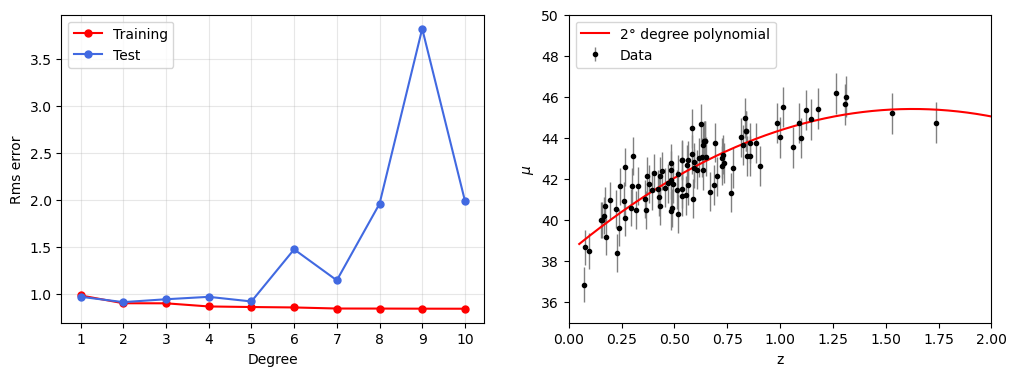

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

#Plotting the RMS error as function of the degrees of the polynomial
axs[0].plot(degreerange, -grid_deg.cv_results_['mean_train_score'], color = 'red', label = 'Training', marker = 'o', ms = 5)
axs[0].plot(degreerange, -grid_deg.cv_results_['mean_test_score'], color = 'royalblue', label = 'Test', marker = 'o', ms = 5)
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('Rms error')
axs[0].set_xticks(degreerange)
axs[0].grid(alpha=0.3)
axs[0].legend()

#Fit with the best degree
axs[1].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
axs[1].plot(z_grid, poly(best_degree), color = 'red', label='%i° degree polynomial' %best_degree)
axs[1].set_xlabel("z")
axs[1].set_ylabel("$\mu$")
axs[1].legend(loc='upper left')
axs[1].set_xlim(0,2)
axs[1].set_ylim(35,50)
plt.show()

## Learning curves

#### Polynomial regression

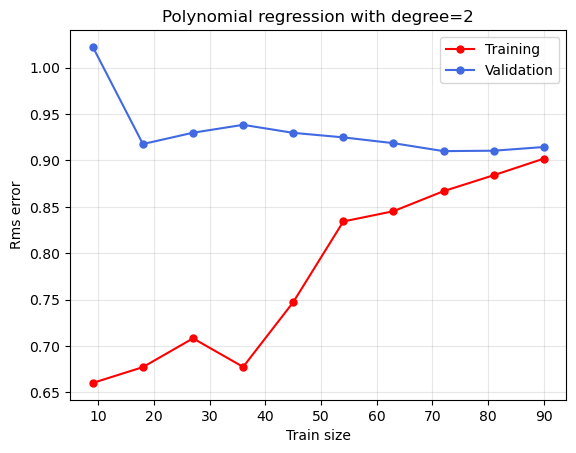

In [18]:
k = 10
train_size, train_scores, validation_scores = learning_curve(PolynomialRegression(best_degree), z_sample[:, np.newaxis],  #Defining the estimator object
                                                             mu_sample, scoring='neg_root_mean_squared_error', 
                                                             train_sizes=np.linspace(0.1, 1, 10), cv=k)

#Plotting the learning curves
plt.plot(train_size, -np.mean(train_scores, axis=1), color = 'red', label = 'Training', marker = 'o', ms = 5)
plt.plot(train_size, -np.mean(validation_scores, axis=1), color = 'royalblue', label = 'Validation', marker = 'o', ms = 5)
plt.title('Polynomial regression with degree=%i' %best_degree)
plt.xlabel('Train size')
plt.ylabel('Rms error')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

The two curves almost converge, we may need a higher number of data points.

In [19]:
#Splitting the data in training and validation data, at first with 70 training points and then with 40
z_train_70, z_cross_70, mudmu_train_70, mudmu_cross_70 = train_test_split(z_sample[:,np.newaxis], np.array([mu_sample,dmu]).T, test_size=0.3, random_state=42)
mu_train_70, dmu_train_70 = mudmu_train_70.T
mu_cross_70, dmu_cross_70 = mudmu_cross_70.T

z_train_40, z_cross_40, mudmu_train_40, mudmu_cross_40 = train_test_split(z_sample[:,np.newaxis], np.array([mu_sample,dmu]).T, test_size=0.6, random_state=42)
mu_train_40, dmu_train_40 = mudmu_train_40.T
mu_cross_40, dmu_cross_40 = mudmu_cross_40.T

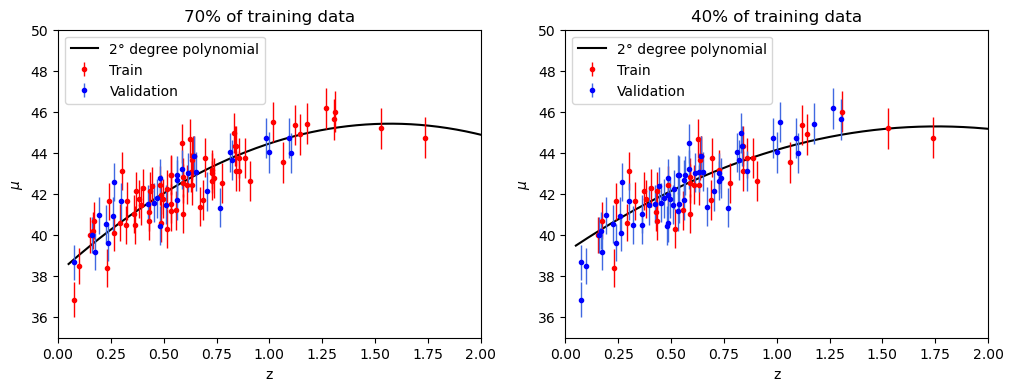

In [20]:
#Fitting with a 2 degree polynomial using at first 70 traing point and then 40
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

poli = PolynomialRegression(best_degree)
poli.fit(z_train_70, mu_train_70, dmu_train_70)
mu_pred =  poli.predict(z_grid[:,np.newaxis])

axs[0].plot(z_grid, mu_pred, color = 'black', label='%i° degree polynomial' %best_degree)
axs[0].errorbar(z_train_70, mu_train_70, dmu_train_70, fmt='.r', ecolor='red', lw=1, label='Train')
axs[0].errorbar(z_cross_70, mu_cross_70, dmu_cross_70, fmt='.b', ecolor='royalblue', lw=1, label='Validation')
axs[0].set_title('70% of training data')
axs[0].set_xlabel("z")
axs[0].set_ylabel("$\mu$")
axs[0].legend(loc='upper left')
axs[0].set_xlim(0,2)
axs[0].set_ylim(35,50)


poli.fit(z_train_40, mu_train_40, dmu_train_40)
mu_pred =  poli.predict(z_grid[:,np.newaxis])

axs[1].plot(z_grid, mu_pred, color = 'black', label='%i° degree polynomial' %best_degree)
axs[1].errorbar(z_train_40, mu_train_40, dmu_train_40, fmt='.r', ecolor='red', lw=1, label='Train')
axs[1].errorbar(z_cross_40, mu_cross_40, dmu_cross_40, fmt='.b', ecolor='royalblue', lw=1, label='Validation')
axs[1].set_title('40% of training data')
axs[1].set_xlabel("z")
axs[1].set_ylabel("$\mu$")
axs[1].legend(loc='upper left')
axs[1].set_xlim(0,2)
axs[1].set_ylim(35,50)

plt.show()